In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from wrangle import acquire_wine, wine_train_val_test, wrangle_wine

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

___
<font size="5">Modeling</font><br>
___

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso

def kbest_features(df, col_name, k=2):
    """
    Selects the top k best features for regression from a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing features and the target column.
        col_name (str): The name of the target column.
        k (int): The number of top features to select (default is 2).

    Returns:
        selected_df (DataFrame): A DataFrame with two columns: 'Column Name' and 'Score'.
            'Column Name' contains the column names of the selected features.

    Example:
        selected_features = select_k_best_features(your_dataframe, 'value', k=2)
    """
    # Create X and y
    X = df.drop(columns=[col_name])  # Remove the target column
    y = df[col_name]
    
    # Filter X to keep only columns that can be converted to float
    X = X.select_dtypes(include=['number', 'float'])  # Keep numeric and float columns
    
    # Initialize SelectKBest with f_regression
    skb = SelectKBest(f_regression, k=k)
    
    # Fit SelectKBest on X and y
    skb.fit(X, y)
    
    # Get the mask of selected features
    skb_mask = skb.get_support()
    
    # Get the scores for all features
    feature_scores = skb.scores_
    
    # Create a DataFrame with column names and scores
    selected_df = pd.DataFrame({
        'Kbest': X.columns[skb_mask],
        'Score': feature_scores[skb_mask]
    })
    
    # Sort the DataFrame by score in descending order
    selected_df = selected_df.sort_values(by='Score', ascending=False)
    
    selected_df.reset_index(drop=True, inplace=True)
    
    selected_df.drop('Score', axis=1, inplace=True)
    
    return selected_df

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------

def rfe_features(df, col_name, n_features=3):
    """
    Selects a specified number of features from a DataFrame using Linear Regression and RFE.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the features and target variable.
        col_name (str): The name of the target column.
        n_features (int): The number of features to select (default is 3).

    Returns:
        pd.Series: A Series containing the selected feature names.
    """
    # Drop the target column from the DataFrame
    X = df.drop(columns=[col_name])
    
    # Select columns with numeric or float data types
    X = X.select_dtypes(include=['number', 'float'])
    
    # Extract the target variable
    y = df[col_name]
    
    # Initialize a Linear Regression model
    lm = LinearRegression()
    
    # Initialize RFE (Recursive Feature Elimination) with the specified number of features to select
    rfe = RFE(lm, n_features_to_select=n_features)
    
    # Fit RFE on the data
    rfe.fit(X, y)
    
    # Get the mask of selected features
    rfe_mask = rfe.get_support()
    
    # Get the column names of selected features
    selected_features = X.columns[rfe_mask]
    
    # Create a DataFrame to present the selected features
    selected_df = pd.DataFrame({'RFE': selected_features})
    
    return selected_df

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------

def lasso_features(df, col_name, k=2):
    """
    Performs LASSO feature selection to select the top k features for regression from a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing features and the target column.
        col_name (str): The name of the target column.
        k (int): The number of top features to select (default is 2).

    Returns:
        selected_df (DataFrame): A DataFrame with two columns: 'Column Name' and 'Coefficient'.
            'Column Name' contains the column names of the selected features.
            'Coefficient' contains the corresponding LASSO regression coefficients.

    Example:
        selected_features = lasso_feature_selection(your_dataframe, 'value', k=2)
    """
    # Create X and y
    X = df.drop(columns=[col_name])  # Remove the target column
    y = df[col_name]
    
    # Filter X to keep only numeric and float columns
    X = X.select_dtypes(include=['number', 'float'])
    
    # Initialize LASSO regression with alpha=1.0 (adjust as needed)
    lasso = Lasso(alpha=0.5, max_iter=100000)
    
    # Fit LASSO on X and y
    lasso.fit(X, y)
    
    # Create a DataFrame with selected column names and their coefficients
    selected_df = pd.DataFrame({
        'Lasso': X.columns,
        'Coefficient': lasso.coef_
    })
    
    # Sort the DataFrame by absolute coefficient value in descending order
    selected_df['Coefficient'] = abs(selected_df['Coefficient'])
    selected_df = selected_df.sort_values(by='Coefficient', ascending=False)
    
    # Keep the top k features
    selected_df = selected_df.head(k)
    
    selected_df.reset_index(drop=True, inplace=True)
    
    selected_df.drop('Coefficient', axis=1, inplace=True)
    
    return selected_df

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------

def feature_selections_results(df, col_name, k=2):
    """
    Combine the results of three feature selection functions into a final DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing features and the target column.
    col_name (str): The name of the target column.
    k (int, optional): The number of top features to select (default is 2).

    Returns:
    DataFrame: A DataFrame containing the selected features from three different feature selection methods.
    """
    selected_df1 = kbest_features(df, col_name, k)
    selected_df2 = rfe_features(df, col_name, k)
    selected_df3 = lasso_features(df, col_name, k)
    
    final_selected_df = pd.concat([selected_df1, selected_df2, selected_df3], axis=1)
    
    return final_selected_df

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------

def MinMax_Scaler(train, val, test):
    """
    Apply Min-Max scaling to selected columns of a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the columns to be scaled.

    Returns:
        pd.DataFrame: The DataFrame with specified columns scaled using Min-Max scaling.

    Note:
        - The function applies Min-Max scaling to numeric columns (float or int) in the DataFrame.
        - The 'value' column is excluded from scaling.
        - The selected columns are scaled to the range [0, 1].
    """
    mms = MinMaxScaler()

    # Select columns to scale (excluding 'value')
    to_scale = train.select_dtypes(include=['float', 'int']).columns.tolist()
    to_scale.remove('quality')

    
    # Apply Min-Max scaling to the selected columns
    train[to_scale] = mms.fit_transform(train[to_scale])
    val[to_scale] = mms.transform(val[to_scale])
    test [to_scale] = mms.transform(test[to_scale])
    
    return train, val, test

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------

def MinMax_Scaler_xy(train, val, test):
    """
    Apply Min-Max scaling to selected columns of a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the columns to be scaled.

    Returns:
        pd.DataFrame: The DataFrame with specified columns scaled using Min-Max scaling.

    Note:
        - The function applies Min-Max scaling to numeric columns (float or int) in the DataFrame.
        - The 'value' column is excluded from scaling.
        - The selected columns are scaled to the range [0, 1].
    """
    mms = MinMaxScaler()

    # Select columns to scale (excluding 'value')
    to_scale = train.select_dtypes(include=['float', 'int']).columns.tolist()

    # Apply Min-Max scaling to the selected columns
    train[to_scale] = mms.fit_transform(train[to_scale])
    val[to_scale] = mms.transform(val[to_scale])
    test [to_scale] = mms.transform(test[to_scale])
    
    return train, val, test

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------

def hot_encode(df):
    """
    Perform one-hot encoding on a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing categorical columns to be one-hot encoded.

    Returns:
        pd.DataFrame: The DataFrame with categorical columns converted to one-hot encoded columns.

    Note:
        - The function uses pd.get_dummies to perform one-hot encoding on the specified DataFrame.
        - All categorical columns are one-hot encoded without dropping the first category (drop_first=False).
    """
    # Use pd.get_dummies to one-hot encode the DataFrame
    df = pd.get_dummies(df, drop_first=True)
    
    return df

def xy_split(df):
    """
    Split the input DataFrame into feature matrix (X) and target vector (y).
    
    Parameters:
    df (DataFrame): The input DataFrame containing features and target.
    
    Returns:
    X (DataFrame): Feature matrix (all columns except 'value').
    y (Series): Target vector (column 'value').
    """
    # Split the dataset into feature columns (X) and target column (y)
    return df.drop(columns=['quality']), df.quality

def data_pipeline(df):
    train, val, test = wine_train_val_test(df)
    
    #train, val, test = scale_train_val_test(train, val, test)
    train = hot_encode(train)
    val = hot_encode(val)
    test = hot_encode(test)
    
    X_train, y_train = xy_split(train)
    X_val, y_val = xy_split(val)
    X_test, y_test = xy_split(test)
    return train, val, test, X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def eval_baseline(y_train):
    """
    Evaluate the baseline model's performance using the root mean squared error (RMSE).

    Parameters:
        y_train (pd.Series): The target variable from the training dataset.

    Returns:
        float: The RMSE score representing the baseline model's performance.

    Note:
        - The function creates a baseline model by predicting the mean value of the training target variable for all samples.
        - It calculates the RMSE between the actual target values and the mean predictions.
        - The RMSE score quantifies the baseline model's performance.
    """
    baselines = pd.DataFrame({'y_actual': y_train, 'y_mean': y_train.mean()})
    
    return sqrt(mean_squared_error(baselines.y_actual, baselines.y_mean))

In [5]:
from sklearn.ensemble import RandomForestRegressor

def eval_model(y_actual, y_hat):
    """
    Evaluate a model's performance using the root mean squared error (RMSE).

    Parameters:
        y_actual (pd.Series): The actual target values.
        y_hat (pd.Series or np.array): The predicted target values.

    Returns:
        float: The RMSE score representing the model's performance.

    Note:
        - The function calculates the RMSE between the actual target values and the predicted values.
        - The RMSE score quantifies the model's performance, where lower values indicate better performance.
    """
    return sqrt(mean_squared_error(y_actual, y_hat))

def update_model_results(model_name, train_rmse, val_rmse, model_results=None):
    """
    Update a DataFrame with model evaluation results (RMSE) for a given model.

    Parameters:
        model_name (str): The name or identifier of the model.
        train_rmse (float): The root mean squared error (RMSE) on the training dataset.
        val_rmse (float): The root mean squared error (RMSE) on the validation dataset.
        model_results (pd.DataFrame, optional): An existing DataFrame containing model results. Default is None.

    Returns:
        pd.DataFrame: An updated DataFrame with the new model's results.

    Note:
        - The function creates a DataFrame with the model's name and RMSE results on the training and validation datasets.
        - If `model_results` is provided, it concatenates the new results with the existing DataFrame.
        - If `model_results` is not provided, it creates a new DataFrame to store the results.
    """
    # Create a DataFrame with model name and RMSE results
    results_df = pd.DataFrame({
        'Model': [model_name],
        'Train_RMSE': [train_rmse],
        'Val_RMSE': [val_rmse]
    })
    
    # Check if model_results already exists
    if model_results is not None:
        # Concatenate results with existing DataFrame
        model_results = pd.concat([model_results, results_df], ignore_index=True)
    else:
        # Create a new DataFrame if it doesn't exist
        model_results = results_df

    return model_results

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------

def train_model(model_name, X_train, y_train, X_val, y_val, model_results=None):
    """
    Train a machine learning model, evaluate its performance, and update the model results DataFrame.

    Parameters:
        model_name (class): The machine learning model class (e.g., LinearRegression).
        X_train (pd.DataFrame): The feature matrix of the training dataset.
        y_train (pd.Series): The target variable of the training dataset.
        X_val (pd.DataFrame): The feature matrix of the validation dataset.
        y_val (pd.Series): The target variable of the validation dataset.
        model_results (pd.DataFrame, optional): An existing DataFrame containing model results. Default is None.

    Returns:
    model: Trained machine learning model.
    model_results: Updated DataFrame containing model name and RMSE results.

    Note:
        - The function trains a machine learning model on the provided training data.
        - It evaluates the model's performance on both the training and validation sets using RMSE.
        - RMSE values are printed for both sets in a formatted manner.
        - The model name is extracted from the class and used for updating the model results DataFrame.
        - If `model_results` is provided, it is updated with the new model's results.
        - If `model_results` is not provided, a new DataFrame is created to store the results.
    """
    # Fit the model on the training data
    model = model_name()
    model.fit(X_train, y_train)
    
    # Make predictions on the training set
    train_preds = model.predict(X_train)
    
    # Calculate RMSE on the training set
    train_rmse = eval_model(y_train, train_preds)
    
    # Make predictions on the validation set
    val_preds = model.predict(X_val)
    
    # Calculate RMSE on the validation set
    val_rmse = eval_model(y_val, val_preds)
    
    # Print RMSE values for training and validation sets (formatted)
    train_rmse_formatted = "${:,.4f}".format(train_rmse)
    val_rmse_formatted = "${:,.4f}".format(val_rmse)
    print(f'The train RMSE is {train_rmse_formatted}.')
    print(f'The validate RMSE is {val_rmse_formatted}.')
    
    # Extract the name of the model class without the module path
    model_name = model.__class__.__name__

    # Update the model results DataFrame
    model_results = update_model_results(model_name, train_rmse_formatted, val_rmse_formatted, model_results)

    return model, model_results


In [6]:
df = acquire_wine()

___
<font size="5">Model First Rounds</font><br>
___

In [7]:
train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = data_pipeline(df)

In [8]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
3761,9.9,0.490,0.23,2.4,0.087,19.0,115.0,0.99480,2.77,0.44,9.400000,6,True
3740,7.7,0.280,0.35,15.3,0.056,31.0,117.0,0.99980,3.27,0.50,9.600000,5,True
1359,11.6,0.475,0.40,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,10.033333,6,False
1230,7.7,0.180,0.34,2.7,0.066,15.0,58.0,0.99470,3.37,0.78,11.800000,6,False
4751,7.6,0.250,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.100000,6,True


In [9]:
eval_baseline(y_train)

0.8812045100258817

In [10]:
rforest, model_results_1 = train_model(RandomForestRegressor, X_train, y_train, X_val, y_val)

The train RMSE is $0.2343.
The validate RMSE is $0.6201.


In [11]:
from xgboost import XGBRegressor

In [12]:
xgbr, model_results_1 = train_model(XGBRegressor, X_train, y_train, X_val, y_val, model_results_1)

The train RMSE is $0.2526.
The validate RMSE is $0.6364.


In [13]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from mlxtend.feature_selection import SequentialFeatureSelector
import numpy as np

# Initialize the linear regression model
lr = LinearRegression()

# Define the Sequential Feature Selector
sfs = SequentialFeatureSelector(lr, 
                                k_features='best',  # Number of features to select ('best' selects the best subset)
                                forward=True,  # Forward selection
                                floating=False,  # No floating feature selection
                                scoring='neg_root_mean_squared_error',  # Scoring metric as RMSE
                                cv=5)  # Cross-validation folds

# Fit SFS to your training data
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices and names
selected_feature_indices = sfs.k_feature_idx_
selected_feature_names = X_train.columns[list(selected_feature_indices)]

# Train a linear regression model with the selected features
lr.fit(X_train[selected_feature_names], y_train)

# Make predictions on the validation set
y_pred = lr.predict(X_val[selected_feature_names])

# Calculate RMSE on the validation set
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("Selected Features:", selected_feature_names)
print("Validation RMSE:", rmse)


Selected Features: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type_white'],
      dtype='object')
Validation RMSE: 0.7268084056792673


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector
import numpy as np

def sfs_forward(X_train, y_train):
    # Initialize the linear regression model
    lr = LinearRegression()

    # Define the Sequential Feature Selector
    sfs = SequentialFeatureSelector(lr, 
                                    k_features='best',  # Number of features to select ('best' selects the best subset)
                                    forward=True,  # Forward selection
                                    floating=False,  # No floating feature selection
                                    scoring='neg_root_mean_squared_error',  # Scoring metric as RMSE
                                    cv=5)  # Cross-validation folds

    # Fit SFS to your training data
    sfs = sfs.fit(X_train, y_train)

    # Get the selected feature indices and names
    selected_feature_indices = sfs.k_feature_idx_
    selected_feature_names = X_train.columns[list(selected_feature_indices)]

    # Train a linear regression model with the selected features
    lr.fit(X_train[selected_feature_names], y_train)

    # Make predictions on the validation set
    y_pred = lr.predict(X_val[selected_feature_names])

    # Calculate RMSE on the validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    print("Selected Features:")
    print(selected_feature_names)
    print("Validation RMSE:", rmse)

    # Find the features that were removed
    removed_features = [feature for feature in X_train.columns if feature not in selected_feature_names]
    print("Removed Features:")
    print(removed_features)


In [16]:
sfs_forward(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type_white'],
      dtype='object')
Validation RMSE: 0.7268084056792673
Removed Features:
[]


In [17]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
import numpy as np


def sfs_backwards(X_train, y_train):
    # Initialize the linear regression model
    lr = LinearRegression()

    # Define the Sequential Feature Selector
    sfs = SequentialFeatureSelector(lr, 
                                    k_features='best',  # Number of features to select ('best' selects the best subset)
                                    forward=False,  # Backward elimination (remove features)
                                    floating=False,  # No floating feature selection
                                    scoring='neg_root_mean_squared_error',  # Scoring metric as RMSE
                                    cv=5)  # Cross-validation folds

    # Fit SFS to your training data
    sfs = sfs.fit(X_train, y_train)

    # Get the selected feature indices and names
    selected_feature_indices = sfs.k_feature_idx_
    selected_feature_names = X_train.columns[list(selected_feature_indices)]

    # Find the removed features
    all_feature_indices = range(X_train.shape[1])
    removed_feature_indices = list(set(all_feature_indices) - set(selected_feature_indices))
    removed_feature_names = X_train.columns[list(removed_feature_indices)]

    # Train a linear regression model with the selected features
    lr.fit(X_train[selected_feature_names], y_train)

    # Print selected features
    print("Selected Features:")
    print(selected_feature_names)

    # Print removed features
    print("Removed Features:")
    print(removed_feature_names)

    # Make predictions on the validation set
    y_pred = lr.predict(X_val[selected_feature_names])

    # Calculate RMSE on the validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    print("Validation RMSE:", rmse)

In [18]:
sfs_backwards(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type_white'],
      dtype='object')
Removed Features:
Index([], dtype='object')
Validation RMSE: 0.7268084056792673


In [19]:
lasso, model_results_1 = train_model(LassoLars, X_train, y_train, X_val, y_val, model_results_1)

The train RMSE is $0.8788.
The validate RMSE is $0.8619.


In [20]:
linearr, model_results_1 = train_model(LinearRegression, X_train, y_train, X_val, y_val, model_results_1)

The train RMSE is $0.7355.
The validate RMSE is $0.7268.


In [21]:
tweedie, model_results_1 = train_model(TweedieRegressor, X_train, y_train, X_val, y_val, model_results_1)

The train RMSE is $0.7908.
The validate RMSE is $0.7780.


#### Non Scaled, No drops, no Cluster features

In [22]:
model_results_1

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.2343,$0.6201
1,XGBRegressor,$0.2526,$0.6364
2,LassoLars,$0.8788,$0.8619
3,LinearRegression,$0.7355,$0.7268
4,TweedieRegressor,$0.7908,$0.7780


____
____

## MODEL SECOND ROUND - SCALED
____
____

In [23]:
df = acquire_wine()

In [24]:
train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = data_pipeline(df)

In [25]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
3761,9.9,0.490,0.23,2.4,0.087,19.0,115.0,0.99480,2.77,0.44,9.400000,6,True
3740,7.7,0.280,0.35,15.3,0.056,31.0,117.0,0.99980,3.27,0.50,9.600000,5,True
1359,11.6,0.475,0.40,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,10.033333,6,False
1230,7.7,0.180,0.34,2.7,0.066,15.0,58.0,0.99470,3.37,0.78,11.800000,6,False
4751,7.6,0.250,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.100000,6,True


In [26]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_white
3761,9.9,0.490,0.23,2.4,0.087,19.0,115.0,0.99480,2.77,0.44,9.400000,True
3740,7.7,0.280,0.35,15.3,0.056,31.0,117.0,0.99980,3.27,0.50,9.600000,True
1359,11.6,0.475,0.40,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,10.033333,False
1230,7.7,0.180,0.34,2.7,0.066,15.0,58.0,0.99470,3.37,0.78,11.800000,False
4751,7.6,0.250,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.100000,True


In [27]:
train, val, test = MinMax_Scaler(train, val, test)

#Scale X_df because data_pipeline does not scale it
X_train, X_val, X_test = MinMax_Scaler_xy(X_train, X_val, X_test)

In [28]:
val.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
5169,0.262712,0.120000,0.219512,0.055215,0.036545,0.130584,0.218935,0.072874,0.299213,0.096591,0.578512,6,True
6388,0.144068,0.360000,0.268293,0.016871,0.046512,0.158076,0.331361,0.009061,0.322835,0.096591,0.917355,6,True
4371,0.203390,0.140000,0.260163,0.046012,0.028239,0.261168,0.390533,0.040293,0.448819,0.085227,0.842975,7,True
1414,0.525424,0.160000,0.479675,0.024540,0.112957,0.013746,0.026627,0.236939,0.362205,0.318182,0.264463,5,False
1738,0.364407,0.133333,0.317073,0.019939,0.033223,0.116838,0.215976,0.100058,0.385827,0.170455,0.628099,6,True


In [29]:
X_val.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_white
5169,0.262712,0.120000,0.219512,0.055215,0.036545,0.130584,0.218935,0.072874,0.299213,0.096591,0.578512,True
6388,0.144068,0.360000,0.268293,0.016871,0.046512,0.158076,0.331361,0.009061,0.322835,0.096591,0.917355,True
4371,0.203390,0.140000,0.260163,0.046012,0.028239,0.261168,0.390533,0.040293,0.448819,0.085227,0.842975,True
1414,0.525424,0.160000,0.479675,0.024540,0.112957,0.013746,0.026627,0.236939,0.362205,0.318182,0.264463,False
1738,0.364407,0.133333,0.317073,0.019939,0.033223,0.116838,0.215976,0.100058,0.385827,0.170455,0.628099,True


In [30]:
eval_baseline(y_train)

0.8812045100258817

In [31]:
# Fit the model on the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)


# Make predictions on the training set
train_preds = model.predict(X_train)

train_rmse = sqrt(mean_squared_error(y_train, train_preds))


# Make predictions on the training set
val_preds = model.predict(X_val)

val_rmse =  sqrt(mean_squared_error(y_val, val_preds))


# Print RMSE values for training and validation sets (formatted)
# train_rmse_formatted = "${:,.2f}".format(train_rmse)
# val_rmse_formatted = "${:,.2f}".format(val_rmse)
# print(f'The train RMSE is {train_rmse_formatted}.')
# print(f'The validate RMSE is {val_rmse_formatted}.')

print(f'The train RMSE is {train_rmse}.')
print(f'The validate RMSE is {val_rmse}.')

The train RMSE is 0.23045928077811728.
The validate RMSE is 0.6191979924435753.


In [32]:
rforest, model_results_2 = train_model(RandomForestRegressor, X_train, y_train, X_val, y_val)

The train RMSE is $0.2344.
The validate RMSE is $0.6170.


In [33]:
from xgboost import XGBRegressor

In [34]:
xgbr, model_results_2 = train_model(XGBRegressor, X_train, y_train, X_val, y_val, model_results_2)

The train RMSE is $0.2526.
The validate RMSE is $0.6364.


In [35]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

In [36]:
sfs_forward(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type_white'],
      dtype='object')
Validation RMSE: 0.7268084056792665
Removed Features:
[]


In [37]:
sfs_backwards(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type_white'],
      dtype='object')
Removed Features:
Index([], dtype='object')
Validation RMSE: 0.7268084056792665


In [38]:
lasso, model_results_2 = train_model(LassoLars, X_train, y_train, X_val, y_val, model_results_2)

The train RMSE is $0.8812.
The validate RMSE is $0.8625.


In [39]:
linearr, model_results_2 = train_model(LinearRegression, X_train, y_train, X_val, y_val, model_results_2)

The train RMSE is $0.7355.
The validate RMSE is $0.7268.


In [40]:
# Fit the model on the training data
model = LinearRegression()
model.fit(X_train, y_train)


# Make predictions on the training set
train_preds = model.predict(X_train)

train_rmse = sqrt(mean_squared_error(y_train, train_preds))


# Make predictions on the training set
val_preds = model.predict(X_val)

val_rmse =  sqrt(mean_squared_error(y_val, val_preds))


# Print RMSE values for training and validation sets (formatted)
# train_rmse_formatted = "${:,.2f}".format(train_rmse)
# val_rmse_formatted = "${:,.2f}".format(val_rmse)
# print(f'The train RMSE is {train_rmse_formatted}.')
# print(f'The validate RMSE is {val_rmse_formatted}.')

print(f'The train RMSE is {train_rmse}.')
print(f'The validate RMSE is {val_rmse}.')

The train RMSE is 0.7355464257822959.
The validate RMSE is 0.7268084056792665.


In [41]:
# Tweedie seems to get worse with scaled data
tweedie, model_results_2 = train_model(TweedieRegressor, X_train, y_train, X_val, y_val, model_results_2)

The train RMSE is $0.8717.
The validate RMSE is $0.8527.


In [42]:
model_results_2

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.2344,$0.6170
1,XGBRegressor,$0.2526,$0.6364
2,LassoLars,$0.8812,$0.8625
3,LinearRegression,$0.7355,$0.7268
4,TweedieRegressor,$0.8717,$0.8527


#### **Scaled**, No drops, no Cluster features

____
____

## MODEL THIRD ROUND
#### Cluster Featrue (alcohol & desity)

Drop Alcohol and Density
____
____

In [53]:
df = acquire_wine()

In [54]:
df = df[df.density <= 1.01]

In [55]:
df = df[df.alcohol <= 14.04]

In [56]:
train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = data_pipeline(df)

In [47]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
3431,7.7,0.44,0.24,11.2,0.031,41.0,167.0,0.99480,3.12,0.43,11.3,7,True
2108,6.0,0.24,0.27,1.9,0.048,40.0,170.0,0.99380,3.64,0.54,10.0,7,True
5828,6.3,0.26,0.25,5.2,0.046,11.0,133.0,0.99202,2.97,0.68,11.0,6,True
5945,6.7,0.27,0.69,1.2,0.176,36.0,106.0,0.99288,2.96,0.43,9.2,6,True
476,9.3,0.27,0.41,2.0,0.091,6.0,16.0,0.99800,3.28,0.70,9.7,5,False


In [57]:
train, val, test = MinMax_Scaler(train, val, test)

#Scale X_df because data_pipeline does not scale it
X_train, X_val, X_test = MinMax_Scaler_xy(X_train, X_val, X_test)

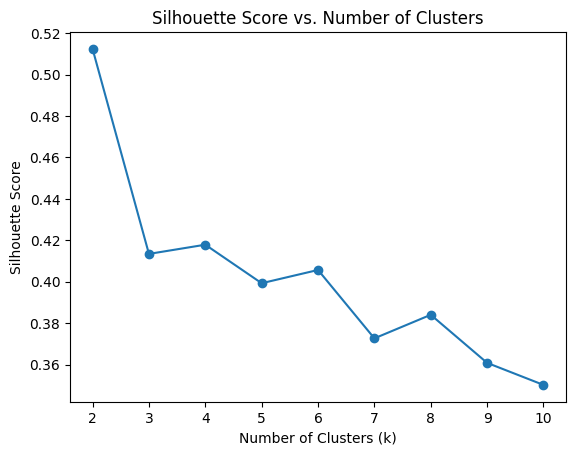

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

features = train[['alcohol', 'density']]
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(features)
    silhouette_scores.append(silhouette_score(features, kmeans.labels_))

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()


In [58]:
kmeans = KMeans(n_clusters=3, n_init='auto')
features = train[['alcohol', 'density']]
kmeans.fit(features)

KMeans(n_clusters=3, n_init='auto')

In [59]:
train['alc_dens_cluster'] = kmeans.labels_

In [67]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white,alc_dens_cluster
1360,0.452991,0.306667,0.186747,0.066798,0.166945,0.068729,0.088766,0.595899,0.403101,0.193182,0.483333,5,False,0
1231,0.333333,0.490000,0.006024,0.078585,0.103506,0.323024,0.233010,0.548854,0.511628,0.227273,0.466667,5,False,0
4749,0.162393,0.206667,0.283133,0.271120,0.025042,0.075601,0.227462,0.216526,0.511628,0.130682,1.000000,6,True,2
4341,0.350427,0.100000,0.168675,0.082515,0.060100,0.329897,0.441054,0.487937,0.418605,0.284091,0.250000,6,True,1
4376,0.316239,0.080000,0.216867,0.051081,0.051753,0.158076,0.291262,0.317250,0.441860,0.181818,0.550000,6,True,0


<function matplotlib.pyplot.show(close=None, block=None)>

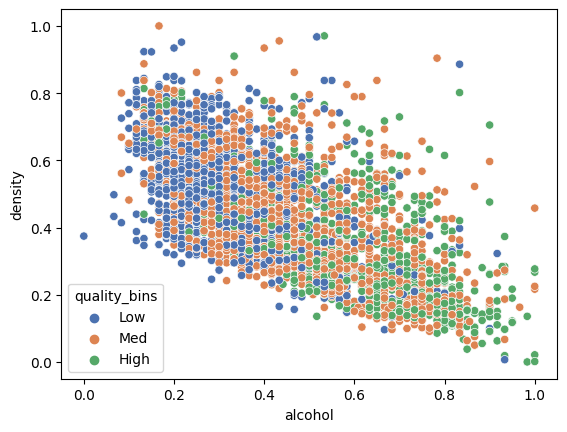

In [53]:
# Define custom labels for "quality"
bins_q = [3, 5, 6, 9]
labels_q = ['Low', 'Med', 'High']

# Create a new column "quality_bins" to store the bin labels
train['quality_bins'] = pd.cut(train['quality'], bins=bins_q, labels=labels_q)

sns.scatterplot(data=train, x='alcohol', y='density', hue='quality_bins', palette='deep')
#plt.ylim(min(train_scaled.density), .5)

# Remove the "quality_bins" column from the DataFrame
train.drop(columns=['quality_bins'], inplace=True)

plt.show

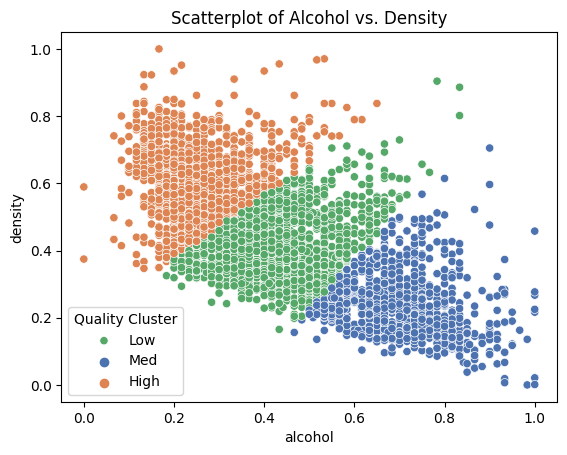

In [62]:
# Define a custom legend labels dictionary
legend_labels = {0: 'Low', 1: 'Med', 2: 'High'}

# Create the scatterplot with Seaborn
sns.scatterplot(data=train, x='alcohol', y='density', hue='alc_dens_cluster', palette='deep')

# Set the title
plt.title("Scatterplot of Alcohol vs. Density")

# Modify the legend title and labels
plt.legend(title="Quality Cluster", labels=[legend_labels[i] for i in range(3)])

# Show the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

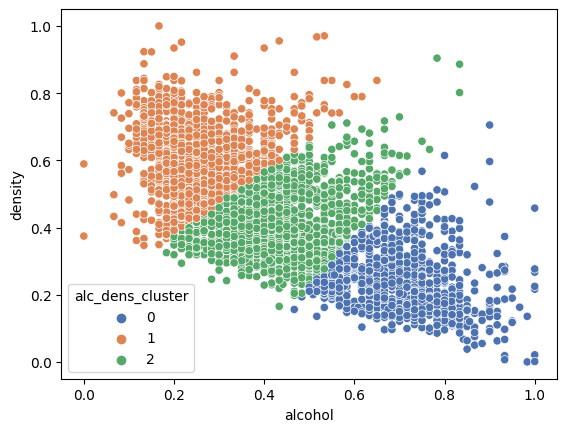

In [61]:
sns.scatterplot(data=train, x='alcohol', y='density', hue='alc_dens_cluster', palette='deep')
#plt.ylim(min(train_scaled.density), .5)
plt.show

In [72]:
def perform_chi2_test(data, variable1, variable2):
    """
    Perform the Chi-Squared Test of Independence and print the results.

    Parameters:
    - data: DataFrame containing the two categorical variables.
    - variable1: Name of the first categorical variable.
    - variable2: Name of the second categorical variable.

    Returns:
    - None (results are printed).
    """
    # Create a contingency table
    contingency_table = pd.crosstab(data[variable1], data[variable2])

    # Perform the Chi-Squared Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print("Chi-Squared Test of Independence:")
    print(f"Chi-Squared Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)


In [79]:
# Define custom labels for "quality"
bins_q = [3, 5, 6, 9]
labels_q = ['Low', 'Med', 'High']

# Create a new column "quality_bins" to store the bin labels
train['quality_bins'] = pd.cut(train['quality'], bins=bins_q, labels=labels_q)

In [80]:
perform_chi2_test(train, 'alc_dens_cluster', 'quality_bins')

Chi-Squared Test of Independence:
Chi-Squared Statistic: 806.8599
P-value: 0.0000
Degrees of Freedom: 2
Expected Frequencies:
[[ 663.24441495  784.81265207  353.94293298]
 [1000.75558505 1184.18734793  534.05706702]]


In [ ]:
# Remove the "quality_bins" column from the DataFrame
train.drop(columns=['quality_bins'], inplace=True)

In [53]:
# Remove the "quality_bins" column from the DataFrame
train.drop(columns=['alcohol', 'density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
val.drop(columns=['alcohol', 'density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
test.drop(columns=['alcohol', 'density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
X_train.drop(columns=['alcohol', 'density'], inplace=True)


# Remove the "quality_bins" column from the DataFrame
X_val.drop(columns=['alcohol', 'density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
X_test.drop(columns=['alcohol', 'density'], inplace=True)


In [54]:
eval_baseline(y_train)

0.8747299331416253

In [55]:
rforest, model_results_3 = train_model(RandomForestRegressor, X_train, y_train, X_val, y_val)

The train RMSE is $0.2436.
The validate RMSE is $0.6735.


In [56]:
from xgboost import XGBRegressor

In [57]:
xgbr, model_results_3 = train_model(XGBRegressor, X_train, y_train, X_val, y_val, model_results_3)

The train RMSE is $0.2790.
The validate RMSE is $0.6928.


In [58]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

In [59]:
sfs_forward(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'sulphates',
       'type_white'],
      dtype='object')
Validation RMSE: 0.8425504795587738
Removed Features:
['residual sugar', 'pH']


In [60]:
sfs_backwards(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'sulphates',
       'type_white'],
      dtype='object')
Removed Features:
Index(['residual sugar', 'pH'], dtype='object')
Validation RMSE: 0.8425504795587738


In [61]:
lasso, model_results_3 = train_model(LassoLars, X_train, y_train, X_val, y_val, model_results_3)

The train RMSE is $0.8747.
The validate RMSE is $0.8988.


In [62]:
linearr, model_results_3 = train_model(LinearRegression, X_train, y_train, X_val, y_val, model_results_3)

The train RMSE is $0.8067.
The validate RMSE is $0.8415.


In [63]:
# Tweedie seems to get worse with scaled data
tweedie, model_results_3 = train_model(TweedieRegressor, X_train, y_train, X_val, y_val, model_results_3)

The train RMSE is $0.8720.
The validate RMSE is $0.8959.


#### Scaled 
#### Drops Density&Alcohol
#### Cluster features Density&Alcohol

In [64]:
model_results_3

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.2436,$0.6735
1,XGBRegressor,$0.2790,$0.6928
2,LassoLars,$0.8747,$0.8988
3,LinearRegression,$0.8067,$0.8415
4,TweedieRegressor,$0.8720,$0.8959


____
____

## MODEL FOURTH ROUND
#### Cluster Featrue (alcohol & desity)

Drop Density
____
____

In [65]:
df = acquire_wine()

In [66]:
df = df[df.density <= 1.01]

In [67]:
df = df[df.alcohol <= 14.04]

In [68]:
train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = data_pipeline(df)

In [69]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
3431,7.7,0.44,0.24,11.2,0.031,41.0,167.0,0.99480,3.12,0.43,11.3,7,True
2108,6.0,0.24,0.27,1.9,0.048,40.0,170.0,0.99380,3.64,0.54,10.0,7,True
5828,6.3,0.26,0.25,5.2,0.046,11.0,133.0,0.99202,2.97,0.68,11.0,6,True
5945,6.7,0.27,0.69,1.2,0.176,36.0,106.0,0.99288,2.96,0.43,9.2,6,True
476,9.3,0.27,0.41,2.0,0.091,6.0,16.0,0.99800,3.28,0.70,9.7,5,False


In [70]:
train, val, test = MinMax_Scaler(train, val, test)

#Scale X_df because data_pipeline does not scale it
X_train, X_val, X_test = MinMax_Scaler_xy(X_train, X_val, X_test)

In [71]:
kmeans = KMeans(n_clusters=3, n_init='auto')
features = train[['alcohol', 'density']]
kmeans.fit(features)

KMeans(n_clusters=3, n_init='auto')

In [72]:
train['alc_dens_cluster'] = kmeans.labels_

In [73]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white,alc_dens_cluster
1360,0.452991,0.306667,0.186747,0.066798,0.166945,0.068729,0.088766,0.595899,0.403101,0.193182,0.483333,5,False,2
1231,0.333333,0.490000,0.006024,0.078585,0.103506,0.323024,0.233010,0.548854,0.511628,0.227273,0.466667,5,False,2
4749,0.162393,0.206667,0.283133,0.271120,0.025042,0.075601,0.227462,0.216526,0.511628,0.130682,1.000000,6,True,0
4341,0.350427,0.100000,0.168675,0.082515,0.060100,0.329897,0.441054,0.487937,0.418605,0.284091,0.250000,6,True,1
4376,0.316239,0.080000,0.216867,0.051081,0.051753,0.158076,0.291262,0.317250,0.441860,0.181818,0.550000,6,True,2


<function matplotlib.pyplot.show(close=None, block=None)>

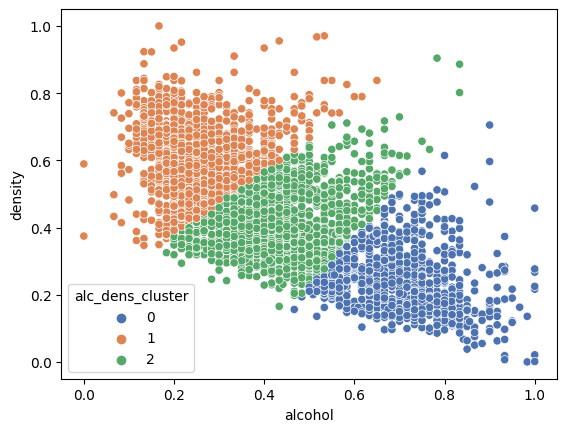

In [74]:
sns.scatterplot(data=train, x='alcohol', y='density', hue='alc_dens_cluster', palette='deep')
#plt.ylim(min(train_scaled.density), .5)
plt.show

In [75]:
# Remove the "quality_bins" column from the DataFrame
train.drop(columns=['density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
val.drop(columns=['density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
test.drop(columns=['density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
X_train.drop(columns=['density'], inplace=True)


# Remove the "quality_bins" column from the DataFrame
X_val.drop(columns=['density'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
X_test.drop(columns=['density'], inplace=True)


In [76]:
eval_baseline(y_train)

0.8747299331416253

In [77]:
rforest, model_results_4 = train_model(RandomForestRegressor, X_train, y_train, X_val, y_val)

The train RMSE is $0.2321.
The validate RMSE is $0.6566.


In [78]:
from xgboost import XGBRegressor

In [79]:
xgbr, model_results_4 = train_model(XGBRegressor, X_train, y_train, X_val, y_val, model_results_4)

The train RMSE is $0.2694.
The validate RMSE is $0.6838.


In [80]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

In [81]:
sfs_forward(X_train, y_train)

Selected Features:
Index(['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol',
       'type_white'],
      dtype='object')
Validation RMSE: 0.7737276858309515
Removed Features:
['fixed acidity', 'pH']


In [82]:
sfs_backwards(X_train, y_train)

Selected Features:
Index(['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol',
       'type_white'],
      dtype='object')
Removed Features:
Index(['fixed acidity', 'pH'], dtype='object')
Validation RMSE: 0.7737276858309515


In [83]:
lasso, model_results_4 = train_model(LassoLars, X_train, y_train, X_val, y_val, model_results_4)

The train RMSE is $0.8747.
The validate RMSE is $0.8988.


In [84]:
linearr, model_results_4 = train_model(LinearRegression, X_train, y_train, X_val, y_val, model_results_4)

The train RMSE is $0.7304.
The validate RMSE is $0.7735.


In [85]:
# Tweedie seems to get worse with scaled data
tweedie, model_results_4 = train_model(TweedieRegressor, X_train, y_train, X_val, y_val, model_results_4)

The train RMSE is $0.8654.
The validate RMSE is $0.8896.


#### Scaled 
#### Drops Density
#### Cluster features Density&Alcohol

In [86]:
model_results_4

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.2321,$0.6566
1,XGBRegressor,$0.2694,$0.6838
2,LassoLars,$0.8747,$0.8988
3,LinearRegression,$0.7304,$0.7735
4,TweedieRegressor,$0.8654,$0.8896


____
____

## MODEL FIFTH ROUND
#### Cluster Featrue (alcohol & desity)

Keep Both! Alcohol and Density
____
____

In [87]:
df = acquire_wine()

In [88]:
df = df[df.density <= 1.01]

In [89]:
df = df[df.alcohol <= 14.04]

In [90]:
train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = data_pipeline(df)

In [91]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_white
1360,9.2,0.540,0.31,2.3,0.112,11.0,38.0,0.99699,3.24,0.56,10.9,False
1231,7.8,0.815,0.01,2.6,0.074,48.0,90.0,0.99621,3.38,0.62,10.8,False
4749,5.8,0.390,0.47,7.5,0.027,12.0,88.0,0.99070,3.38,0.45,14.0,True
4341,8.0,0.230,0.28,2.7,0.048,49.0,165.0,0.99520,3.26,0.72,9.5,True
4376,7.6,0.200,0.36,1.9,0.043,24.0,111.0,0.99237,3.29,0.54,11.3,True


In [92]:
train, val, test = MinMax_Scaler(train, val, test)

#Scale X_df because data_pipeline does not scale it
X_train, X_val, X_test = MinMax_Scaler_xy(X_train, X_val, X_test)

In [93]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
1360,0.452991,0.306667,0.186747,0.066798,0.166945,0.068729,0.088766,0.595899,0.403101,0.193182,0.483333,5,False
1231,0.333333,0.490000,0.006024,0.078585,0.103506,0.323024,0.233010,0.548854,0.511628,0.227273,0.466667,5,False
4749,0.162393,0.206667,0.283133,0.271120,0.025042,0.075601,0.227462,0.216526,0.511628,0.130682,1.000000,6,True
4341,0.350427,0.100000,0.168675,0.082515,0.060100,0.329897,0.441054,0.487937,0.418605,0.284091,0.250000,6,True
4376,0.316239,0.080000,0.216867,0.051081,0.051753,0.158076,0.291262,0.317250,0.441860,0.181818,0.550000,6,True


In [94]:
kmeans = KMeans(n_clusters=3, n_init='auto')
features = train[['alcohol', 'density']]
kmeans.fit(features)

KMeans(n_clusters=3, n_init='auto')

In [95]:
train['alc_dens_cluster'] = kmeans.labels_

In [96]:
eval_baseline(y_train)

0.8747299331416253

In [97]:
rforest, model_results_5 = train_model(RandomForestRegressor, X_train, y_train, X_val, y_val)

The train RMSE is $0.2297.
The validate RMSE is $0.6529.


In [98]:
from xgboost import XGBRegressor

In [99]:
xgbr, model_results_5 = train_model(XGBRegressor, X_train, y_train, X_val, y_val, model_results_5)

The train RMSE is $0.2429.
The validate RMSE is $0.6915.


In [100]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

In [101]:
sfs_forward(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'type_white'],
      dtype='object')
Validation RMSE: 0.7690405840780594
Removed Features:
['chlorides']


In [102]:
sfs_backwards(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'type_white'],
      dtype='object')
Removed Features:
Index(['chlorides'], dtype='object')
Validation RMSE: 0.7690405840780594


In [103]:
lasso, model_results_5 = train_model(LassoLars, X_train, y_train, X_val, y_val, model_results_5)

The train RMSE is $0.8747.
The validate RMSE is $0.8988.


In [104]:
linearr, model_results_5 = train_model(LinearRegression, X_train, y_train, X_val, y_val, model_results_5)

The train RMSE is $0.7262.
The validate RMSE is $0.7689.


In [105]:
# Tweedie seems to get worse with scaled data
tweedie, model_results_5 = train_model(TweedieRegressor, X_train, y_train, X_val, y_val, model_results_5)

The train RMSE is $0.8633.
The validate RMSE is $0.8874.


#### Scaled 
#### Drops NONE
#### Cluster features Density&Alcohol

In [106]:
model_results_5

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.2297,$0.6529
1,XGBRegressor,$0.2429,$0.6915
2,LassoLars,$0.8747,$0.8988
3,LinearRegression,$0.7262,$0.7689
4,TweedieRegressor,$0.8633,$0.8874


____
____

## MODEL SIXTH ROUND
#### Cluster Featrue (alcohol & desity)

Drop Alcohol
____
____

In [107]:
df = acquire_wine()

In [108]:
df = df[df.density <= 1.01]

In [109]:
df = df[df.alcohol <= 14.04]

In [110]:
train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = data_pipeline(df)

In [111]:
train, val, test = MinMax_Scaler(train, val, test)

#Scale X_df because data_pipeline does not scale it
X_train, X_val, X_test = MinMax_Scaler_xy(X_train, X_val, X_test)

In [112]:
kmeans = KMeans(n_clusters=3, n_init='auto')
features = train[['alcohol', 'density']]
kmeans.fit(features)

KMeans(n_clusters=3, n_init='auto')

In [113]:
train['alc_dens_cluster'] = kmeans.labels_

In [114]:
# Remove the "quality_bins" column from the DataFrame
train.drop(columns=['alcohol'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
val.drop(columns=['alcohol'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
test.drop(columns=['alcohol'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
X_train.drop(columns=['alcohol'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
X_val.drop(columns=['alcohol'], inplace=True)

# Remove the "quality_bins" column from the DataFrame
X_test.drop(columns=['alcohol'], inplace=True)


In [115]:
eval_baseline(y_train)

0.8747299331416253

In [116]:
rforest, model_results_6 = train_model(RandomForestRegressor, X_train, y_train, X_val, y_val)

The train RMSE is $0.2333.
The validate RMSE is $0.6464.


In [117]:
from xgboost import XGBRegressor

In [118]:
xgbr, model_results_6 = train_model(XGBRegressor, X_train, y_train, X_val, y_val, model_results_6)

The train RMSE is $0.2720.
The validate RMSE is $0.6838.


In [119]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

In [120]:
sfs_forward(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'residual sugar',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'type_white'],
      dtype='object')
Validation RMSE: 0.7722952527866775
Removed Features:
['citric acid', 'chlorides']


In [121]:
sfs_backwards(X_train, y_train)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'residual sugar',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'type_white'],
      dtype='object')
Removed Features:
Index(['citric acid', 'chlorides'], dtype='object')
Validation RMSE: 0.7722952527866775


In [122]:
lasso, model_results_6 = train_model(LassoLars, X_train, y_train, X_val, y_val, model_results_6)

The train RMSE is $0.8747.
The validate RMSE is $0.8988.


In [123]:
linearr, model_results_6 = train_model(LinearRegression, X_train, y_train, X_val, y_val, model_results_6)

The train RMSE is $0.7321.
The validate RMSE is $0.7720.


In [124]:
# Tweedie seems to get worse with scaled data
tweedie, model_results_6 = train_model(TweedieRegressor, X_train, y_train, X_val, y_val, model_results_6)

The train RMSE is $0.8696.
The validate RMSE is $0.8934.


#### Scaled 
#### Drops Alcohol
#### Cluster features Density&Alcohol

In [125]:
model_results_6

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.2333,$0.6464
1,XGBRegressor,$0.2720,$0.6838
2,LassoLars,$0.8747,$0.8988
3,LinearRegression,$0.7321,$0.7720
4,TweedieRegressor,$0.8696,$0.8934


#### First
- Non Scaled
- No drops
- no Cluster features

In [111]:
model_results_1
#This is the best Tweeedie performed

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.24,$0.62
1,XGBRegressor,$0.25,$0.64
2,LassoLars,$0.88,$0.86
3,LinearRegression,$0.74,$0.73
4,TweedieRegressor,$0.79,$0.78


#### SECOND
- Yes Scaled 
- No drops
- no Cluster features

In [112]:
model_results_2
#The only improved model was LassoLars
#All Others degradedu


,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.23,$0.62
1,XGBRegressor,$0.25,$0.64
2,LassoLars,$0.88,$0.86
3,LinearRegression,$0.74,$0.73
4,TweedieRegressor,$0.87,$0.85


#### Third 
- Yes Scaled 
- Drops Density / Alcohol
- Cluster features Density vs Alcohol

In [112]:
model_results_3
#The only improved model was LassoLars
#All Others degraded
#The degration was less than scaling alone

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.24,$0.68
1,XGBRegressor,$0.28,$0.69
2,LassoLars,$0.87,$0.90
3,LinearRegression,$0.81,$0.84
4,TweedieRegressor,$0.87,$0.90


#### Fourth 
- Yes Scaled 
- Drops Density
- Cluster features Density vs Alcohol

In [113]:
model_results_4
#this improved LR above unscaled/no_n features

# LR saw an improvement when cluster feature was added. 
# No change from dropping either or all dependent variable (alcohol/density)

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.23,$0.65
1,XGBRegressor,$0.27,$0.68
2,LassoLars,$0.87,$0.90
3,LinearRegression,$0.73,$0.77
4,TweedieRegressor,$0.87,$0.89


#### Fifth 
- Yes Scaled 
- Drops NONE
- Cluster features Density vs Alcohol

In [114]:
model_results_5

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.23,$0.65
1,XGBRegressor,$0.24,$0.69
2,LassoLars,$0.87,$0.90
3,LinearRegression,$0.73,$0.77
4,TweedieRegressor,$0.86,$0.89


#### Sixth 
- Yes Scaled 
- Drops Alcohol
- Cluster features Density vs Alcohol

In [115]:
model_results_6

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.23,$0.65
1,XGBRegressor,$0.27,$0.68
2,LassoLars,$0.87,$0.90
3,LinearRegression,$0.73,$0.77
4,TweedieRegressor,$0.87,$0.89


In [117]:
model_results_6

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.23,$0.65
1,XGBRegressor,$0.27,$0.68
2,LassoLars,$0.87,$0.90
3,LinearRegression,$0.73,$0.77
4,TweedieRegressor,$0.87,$0.89


In [118]:
# Create a list of the dataframes
dataframes = [model_results_1, model_results_2, model_results_3, model_results_4, model_results_5, model_results_6]

# Concatenate them horizontally
result = pd.concat(dataframes, axis=1)

# Reset the index if needed
# result.reset_index(drop=True, inplace=True)

# Print or use the resulting dataframe 'result'
result

,Model,Train_RMSE,Val_RMSE,Model,Train_RMSE,Val_RMSE,Model,Train_RMSE,Val_RMSE,Model,Train_RMSE,Val_RMSE,Model,Train_RMSE,Val_RMSE,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,$0.23,$0.62,RandomForestRegressor,$0.23,$0.62,RandomForestRegressor,$0.24,$0.68,RandomForestRegressor,$0.23,$0.65,RandomForestRegressor,$0.23,$0.65,RandomForestRegressor,$0.23,$0.65
1,XGBRegressor,$0.25,$0.64,XGBRegressor,$0.25,$0.64,XGBRegressor,$0.28,$0.69,XGBRegressor,$0.27,$0.68,XGBRegressor,$0.24,$0.69,XGBRegressor,$0.27,$0.68
2,LassoLars,$0.88,$0.86,LassoLars,$0.88,$0.86,LassoLars,$0.87,$0.90,LassoLars,$0.87,$0.90,LassoLars,$0.87,$0.90,LassoLars,$0.87,$0.90
3,LinearRegression,$0.74,$0.73,LinearRegression,$0.74,$0.73,LinearRegression,$0.81,$0.84,LinearRegression,$0.73,$0.77,LinearRegression,$0.73,$0.77,LinearRegression,$0.73,$0.77
4,TweedieRegressor,$0.79,$0.78,TweedieRegressor,$0.87,$0.85,TweedieRegressor,$0.87,$0.90,TweedieRegressor,$0.87,$0.89,TweedieRegressor,$0.86,$0.89,TweedieRegressor,$0.87,$0.89
